pts 46268
0.014173233043272029


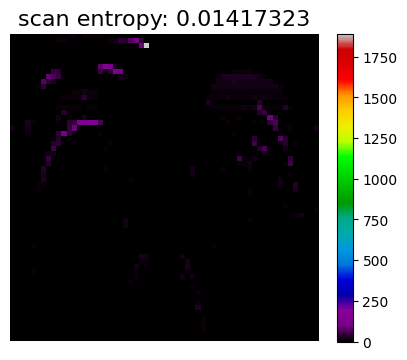

0.002961309271117034


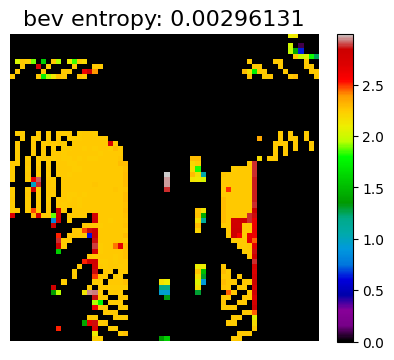

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import argparse


class context_exp:
    def __init__(self) -> None:
        self.PC_MAX_RANGE = 60
        self.PC_NUM_RING = 60
        self.PC_NUM_SECTOR = 60
        self.PC_ENTROPY_SCORE_LIMIT = 0.4

        self.PC_MIN_Z = -2.3
        self.PC_MAX_Z = 0.7

    def read_data(self, source_dir):
        pcd = np.fromfile(source_dir,dtype=np.dtype([
                                       ('x', np.float32),
                                       ('y', np.float32),
                                       ('z', np.float32),
                                       ('CosAngle', np.float32),
                                       ('ObjIdx', np.uint32),
                                       ('ObjTag', np.uint32)
                                   ]) ,count=-1)
        pcd = np.array([list(elem) for elem in pcd])
        return pcd
    
    def scan_context(self, semantic_pt):
        scan_desc = np.zeros((self.PC_NUM_RING, self.PC_NUM_SECTOR))    

        pt_x = semantic_pt[:, 0]
        pt_y = semantic_pt[:, 1]
        pt_z = semantic_pt[:, 2]

        valid_indices = np.where((pt_z < self.PC_MAX_Z) & (pt_z > self.PC_MIN_Z))
        pt_x = pt_x[valid_indices]
        pt_y = pt_y[valid_indices]
        pt_z = pt_z[valid_indices]

        azim_range = np.sqrt(pt_x ** 2+ pt_y ** 2)
        azim_angle = np.rad2deg(np.arctan2(pt_y, pt_x))
        azim_angle[azim_angle < 0] += 360

        valid_indices = np.where(azim_range < self.PC_MAX_RANGE) 
        azim_sector = np.floor(azim_angle[valid_indices] / (360 / self.PC_NUM_SECTOR)).astype(np.int32)
        azim_ring = np.floor(azim_range[valid_indices] / (self.PC_MAX_RANGE / self.PC_NUM_RING)).astype(np.int32)

        np.add.at(scan_desc, (azim_ring, azim_sector), 1)

        scan_entropy = self.scene_entropy(scan_desc, semantic_pt[:, :3])
        print(scan_entropy)

        return scan_desc, scan_entropy
    
    def bev_context(self,semantic_pt):

        bev_max = np.zeros((self.PC_MAX_RANGE, self.PC_MAX_RANGE))
        bev_min = np.zeros((self.PC_MAX_RANGE, self.PC_MAX_RANGE))
        pt_range = self.PC_MAX_RANGE / 2    

        pt_x = semantic_pt[:, 0]
        pt_y = semantic_pt[:, 1]
        pt_z = semantic_pt[:, 2]

        valid_indices = np.where((pt_z < self.PC_MAX_Z) & (pt_z > self.PC_MIN_Z))     
        pt_x = pt_x[valid_indices]
        pt_y = pt_y[valid_indices]
        pt_z = pt_z[valid_indices]

        valid_indices = np.where((pt_x < pt_range) & (pt_x > -pt_range) & (pt_y < pt_range) & (pt_y > -pt_range))
        pt_x_valid = pt_x[valid_indices] + pt_range
        pt_y_valid = pt_y[valid_indices] + pt_range
        pt_z_valid = pt_z[valid_indices]

        bev_max_indices = (pt_x_valid.astype(int), pt_y_valid.astype(int))
        np.maximum.at(bev_max, bev_max_indices, pt_z_valid)

        bev_min_indices = (pt_x_valid.astype(int), pt_y_valid.astype(int))
        np.minimum.at(bev_min, bev_min_indices, pt_z_valid)

        bev_scan = np.subtract(bev_max, bev_min)

        bev_entropy = self.scene_entropy(bev_scan, semantic_pt[:, :3])
        print(bev_entropy)

        return bev_scan, bev_entropy

    def scene_entropy(self,desc,pcd):
        max_pcd = np.max(pcd,axis=0)
        min_pcd = np.min(pcd,axis=0)
        vt = len(pcd) / (max_pcd[0]-min_pcd[0])*(max_pcd[1]-min_pcd[1])*(max_pcd[2]-min_pcd[2])
        nonzero_indices = np.nonzero(desc)
        vi = desc[nonzero_indices]
        entropy = -np.sum((vi /vt) * np.log(vi /vt))

        return entropy

    def read_parser(self):
        parser = argparse.ArgumentParser(description='Process some integers.')
        parser.add_argument('--source', '-s', type=str, help='source dir')
        args = parser.parse_args()
        return args.source

    def draw_heatmap(self, matrix,name,ep):
        plt.figure(figsize=(5, 4))
        plt.imshow(matrix, cmap='nipy_spectral', interpolation='nearest')
        plt.title(name+' entropy: '+str(round(ep,8)), fontsize=16)
        plt.colorbar()
        plt.axis('off')
        plt.savefig('./heatmaps/2'+name+'.pdf')
        plt.show()

    def main(self):
        #source_dir = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0116_0125/vehicle.tesla.model3.master/velodyne/0000023172.bin'
        source_dir = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0116_0132/vehicle.tesla.model3.master/velodyne/0000026765.bin'
        #source_dir = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0116_0140/vehicle.tesla.model3.master/velodyne/0000030193.bin'
        
        semantic_pt = self.read_data(source_dir)
        print("pts",len(semantic_pt))
        scan_desc, scan_ep = self.scan_context(semantic_pt)
        self.draw_heatmap(scan_desc,"scan",scan_ep)

        bev_scan, bev_ep = self.bev_context(semantic_pt)
        self.draw_heatmap(bev_scan,"bev",bev_ep)

if __name__ == "__main__":
    context_exp = context_exp()
    context_exp.main()

In [65]:
scan1 = 0.021868209
scan2 = 0.021111465
scan3 = 0.021178179

bev1 = 0.002478294
bev2 = 0.002389773
bev3 = 0.00242554

# 计算变化率
scan_rate = (scan2-scan1)/scan1
bev_rate = (bev2-bev1)/bev1
print(scan_rate,bev_rate)

scan_rate = (scan3-scan2)/scan2
bev_rate = (bev3-bev2)/bev2
print(scan_rate,bev_rate)

-0.03460475432624593 -0.03571852249975178
0.0031600838691203557 0.014966693489297902
